In [196]:
import pandas as pd 
import matplotlib.pyplot as plt
import os, glob, sys, re
from os.path import join
from nilearn import image
import numpy as np
import seaborn as sns
import json
import argparse
from pathlib import Path
import psutil
import matplotlib.patches as patches
import base64
import ipywidgets as widgets
from IPython.display import display

## overview

This notebook plots the heatmap of pairwise correlations of each fmriprep'd run.
It also layers the folliwng information
* Bad runs identified through fmriprep IQMs
* Runs with no fieldmaps (see if this led to low correlations across images)
* Top 3 correlation coefficients
* Bottom 3 correlation coefficients
* Plot of pairwise images for the identified correlation coefficients
* An animation of the runs, to visualize discrepancies across runs
* An animation of the sbrefs (While they are images prior to alignment, it might provide insight, given that fmriprep uses the sbref for coregistraion)

## Neurostars threads related to sbrefs and coregistration
* [Single band reference scan settings](https://neurostars.org/t/single-band-reference-scan-settings/16846/5)
* [Using sbrefs for multiple functional runs in fmriprep](https://neurostars.org/t/using-sbrefs-for-multiple-functional-runs-in-fmriprep/19587/9)
* [Fmriprep coreg figures](https://neurostars.org/t/fmriprep-coreg-figures/4334/7)
* [FmriPrep SDC Fails to Associate To Bold Image, Preprocess Working](https://neurostars.org/t/fmriprep-sdc-fails-to-associate-to-bold-image-preprocess-working/22568)
* [naming multiple fieldmaps for different tasks](https://neurostars.org/t/naming-multiple-fieldmaps-for-different-tasks-bids/5924/4)
* [Making Sure that the SDC has well-Applied](https://neurostars.org/t/making-sure-that-the-sdc-has-well-applied/25513)

In [314]:
def plot_corr_pair(plot_dir, corr_df, index_list, title):
    from PIL import Image, ImageDraw, ImageFont
    from IPython.display import display
    from matplotlib import font_manager
    from PIL import Image, ImageDraw, ImageFont

    # scale image
    scale_factor = 0.6
    font_size = 40
    # Define the font size
    font = font_manager.FontProperties(family='sans-serif', weight='regular')
    file = font_manager.findfont(font)
    print(file)
    font = ImageFont.truetype(file, 30)

    for ind in index_list:
        # plot_dir = '/Volumes/derivatives/fmriprep_qc/runwisecorr'
        img_name = join(plot_dir, sub, f"corr_{sub}_x-{corr_df.columns[ind[0]+1]}_y-{ind[1]}.png")
        corr_value = corr_df.at[ind[0], ind[1]]  # Get the value from the DataFrame

        image = Image.open(img_name)
        new_size = (int(image.width * scale_factor), int(image.height * scale_factor))
        resized_image = image.resize(new_size)
        # add text
        draw = ImageDraw.Draw(resized_image)
        text = f"{title}: {np.round(corr_value, 5)}"
        text_position = (10, 10)  # Adjust the position according to your requirements
        draw.text(text_position, text, fill="black", font=font)#, font=font)

        display(resized_image)


In [234]:
sub = 'sub-0002'

In [357]:
corr_df = pd.read_csv(f'/Volumes/derivatives/fmriprep_qc/runwisecorr/{sub}/{sub}_runwisecorrelation.csv')

In [237]:
corr_df.head()

,Unnamed: 0,ses-01_run-01,ses-01_run-02,ses-01_run-03,ses-01_run-04,ses-01_run-05,ses-01_run-06,ses-03_run-01,ses-03_run-02,ses-03_run-03,ses-03_run-04,ses-03_run-05,ses-03_run-06,ses-04_run-01,ses-04_run-02,ses-04_run-03,ses-04_run-04,ses-04_run-05,ses-04_run-06
0,ses-01_run-01,NaN,0.944929,0.917364,0.941456,0.943735,0.925240,0.933646,0.879468,0.897132,0.924625,0.905029,0.868052,0.937939,0.917920,0.921927,0.924604,0.916646,0.927481
1,ses-01_run-02,NaN,NaN,0.971365,0.967797,0.949655,0.881256,0.899239,0.827786,0.892129,0.883725,0.893552,0.901411,0.942054,0.936045,0.945749,0.890906,0.951370,0.922191
2,ses-01_run-03,NaN,NaN,NaN,0.950482,0.942874,0.858496,0.879145,0.806859,0.866112,0.862699,0.878636,0.909251,0.921551,0.927674,0.937365,0.866967,0.948687,0.908722
3,ses-01_run-04,NaN,NaN,NaN,NaN,0.961581,0.898728,0.891927,0.826845,0.874061,0.875864,0.880609,0.878204,0.930213,0.918553,0.922467,0.878408,0.933308,0.918601
4,ses-01_run-05,NaN,NaN,NaN,NaN,NaN,0.899419,0.881786,0.835117,0.869093,0.878006,0.861570,0.857615,0.927681,0.930615,0.932583,0.880015,0.933365,0.935898


## load bad data metadata

In [238]:
with open("/Users/h/Documents/projects_local/spacetop-prep/spacetop_prep/qcplot/boldcorrelation/bad_runs.json", "r") as json_file:
    bad_dict = json.load(json_file)
bad_runs = []
if bad_dict.get(sub, 'empty') != 'empty':
    bad_runs = bad_dict[sub]

fullruns = corr_df.iloc[:,0]
badrun_strings = []
badrun_indices = []
for badrun in bad_runs:
    bad_number = re.search(r'ses-(\d+)_run-(\d+)', badrun)
    if bad_number:
        ses_number, run_number = bad_number.group(1, 2)
        for i, fullrun in enumerate(fullruns):
            full_number = re.search(r'ses-(\d+)_run-(\d+)', fullrun)
            if full_number and int(full_number.group(1)) == int(ses_number) and int(full_number.group(2)) == int(run_number):
                badrun_indices.append(i)
                badrun_strings.append(fullrun)
                break

load bad data metadata


In [240]:
badrun_strings

['ses-03_run-04', 'ses-04_run-03', 'ses-04_run-04']

## load fieldmapless metadata

In [241]:
task = 'task-social'
print("load missing fieldmap data metadata")
with open("/Users/h/Documents/projects_local/spacetop-prep/spacetop_prep/qcplot/not_in_intendedFor.json", "r") as json_file:
    missfieldmap_dict = json.load(json_file)
nofieldmap_runs = []
if missfieldmap_dict[task].get(sub, 'empty') != 'empty':
    nofieldmap_runs = missfieldmap_dict[task][sub]

fullruns = corr_df.iloc[:,0]
nofieldmap_indices = []
for nofieldmap in nofieldmap_runs:
    nofieldmap_number = re.search(r'ses-(\d+)_run-(\d+)', nofieldmap)
    if nofieldmap_number:
        ses_nofieldmap, run_nofieldmap = nofieldmap_number.group(1, 2)
        for i, fullrun in enumerate(fullruns):
            full_nofieldmap = re.search(r'ses-(\d+)_run-(\d+)', fullrun)
            if full_nofieldmap and int(full_nofieldmap.group(1)) == int(ses_nofieldmap) and int(full_nofieldmap.group(2)) == int(run_nofieldmap):
                nofieldmap_indices.append(i)
                break

load missing fieldmap data metadata


In [244]:
corr_df.columns

Index(['Unnamed: 0', 'ses-01_run-01', 'ses-01_run-02', 'ses-01_run-03',
       'ses-01_run-04', 'ses-01_run-05', 'ses-01_run-06', 'ses-03_run-01',
       'ses-03_run-02', 'ses-03_run-03', 'ses-03_run-04', 'ses-03_run-05',
       'ses-03_run-06', 'ses-04_run-01', 'ses-04_run-02', 'ses-04_run-03',
       'ses-04_run-04', 'ses-04_run-05', 'ses-04_run-06'],
      dtype='object')

In [338]:
ticks+1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

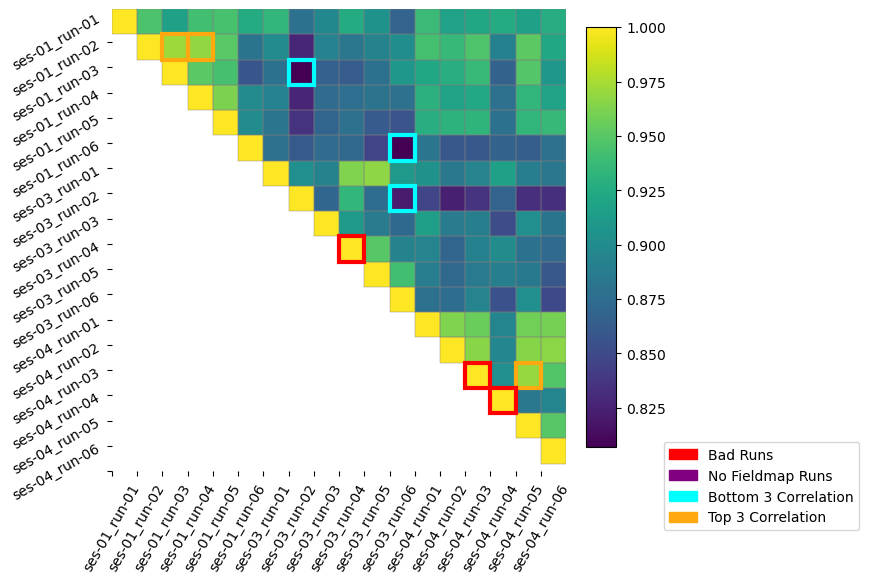

In [368]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# get top, bottom correlation first _____________________________________________________________
clean_corrdf = corr_df.iloc[:, 1:]
top_three_indices = clean_corrdf.stack().nlargest(3).index
bottom_three_indices = clean_corrdf.stack().nsmallest(3).index

# insert 1s in identity line ____________________________________________________________________
num_rows, num_cols = clean_corrdf.shape
for i in range(num_rows):
    j = i   # Calculate the column index based on the row index
    clean_corrdf.iloc[i, j] = 1
# plot heatmap __________________________________________________________________________________
fig, (ax_heatmap) = plt.subplots(1, 1, figsize=(10, 6), gridspec_kw={'width_ratios': [10]})
heatmap = sns.heatmap(clean_corrdf.values, cmap='viridis', annot=False, fmt='.2f', square=True, ax=ax_heatmap)
heatmap.collections[0].colorbar.remove()
# tweak colorbar position _______________________________________________________________________
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust the position and size of the colorbar
heatmap = ax_heatmap.collections[0]
plt.colorbar(heatmap, cax=cbar_ax)

names = np.array(clean_corrdf.columns)
ticks = np.arange(0, 18)
ax_heatmap.set_xticks(ticks)
ax_heatmap.set_yticks(ticks+1.3)
ax_heatmap.set_xticklabels(names, rotation=60)
ax_heatmap.set_yticklabels(names, rotation=30)

# outline upper triangle grid _____________________________________________________________________
num_rows, num_cols = len(clean_corrdf), len(clean_corrdf)

for i in range(num_rows):
    for j in range(i, num_cols):
        rect = plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='gray', linewidth=.3)
        ax_heatmap.add_patch(rect)

# outline a cell for lowest correlation _________________________________________
# bottom_three_indices = corr_df.iloc[:, 1:].stack().nsmallest(3).index
for index in bottom_three_indices:
    cell_to_outline = (index[0], clean_corrdf.columns.get_loc(index[1]))#corr_df.columns.get_loc(index[1]) - 1)  # Adjust column index by subtracting 1
    cell_x = cell_to_outline[1] + 0.5  # Calculate the coordinates of the cell
    cell_y = cell_to_outline[0] + 0.5
    rect = plt.Rectangle((cell_x - 0.5, cell_y - 0.5), 1, 1, edgecolor='cyan', linewidth=3, fill=False)
    ax_heatmap.add_patch(rect)

# Get the top three highest correlations _________________________________________
# top_three_indices = corr_df.iloc[:, 1:].stack().nlargest(3).index
for index in top_three_indices:
    cell_to_outline = (index[0], clean_corrdf.columns.get_loc(index[1]))#corr_df.columns.get_loc(index[1]) - 1)  # Adjust column index by subtracting 1
    cell_x = cell_to_outline[1] + 0.5  # Calculate the coordinates of the cell
    cell_y = cell_to_outline[0] + 0.5
    rect = plt.Rectangle((cell_x - 0.5, cell_y - 0.5), 1, 1, edgecolor='#FFA80F', linewidth=3, fill=False)
    ax_heatmap.add_patch(rect)
# bad runs based on fmriprep image parameters _________________________________________
if badrun_indices:
    for i in np.arange(len(badrun_indices)):
        highlight_row = badrun_indices[i]
        highlight_column = badrun_indices[i]
        num_rows, num_cols = corr_df.shape
        ax_heatmap.add_patch(plt.Rectangle((highlight_column, highlight_row), 1, 1, fill=False, edgecolor='red', lw=3))

# runs with no corresponding fieldmap _________________________________________
if nofieldmap_indices:
    for i in np.arange(len(badrun_indices)):
        highlight_row = nofieldmap_indices[i]
        highlight_column = nofieldmap_indices[i]
        num_rows, num_cols = corr_df.shape
        ax_heatmap.add_patch(plt.Rectangle((highlight_column, highlight_row), 1, 1, fill=False, edgecolor='purple', lw=3))

# Legend _________________________________________
legend_patches = [
    patches.Patch(facecolor='red', edgecolor='red', label='Bad Runs'),
    patches.Patch(facecolor='purple', edgecolor='purple', label='No Fieldmap Runs'),
    patches.Patch(facecolor='cyan', edgecolor='cyan', label='Bottom 3 Correlation'),
    patches.Patch(facecolor='#FFA80F', edgecolor='#FFA80F', label='Top 3 Correlation')
]
fig.legend(handles=legend_patches, loc='lower right', bbox_to_anchor=(1.2, 0.0))
# fig.legend(handles=legend_patches, loc='lower right')  # Place the legend beneath the colorbar

plt.show()


## plot top 3 correlation pairs

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf


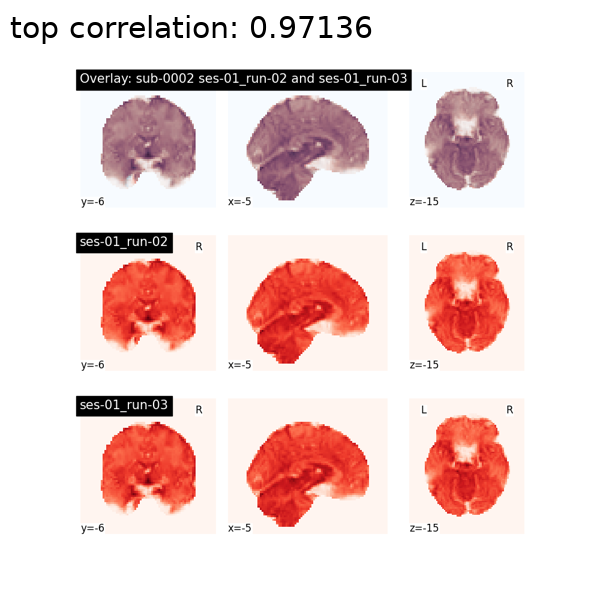

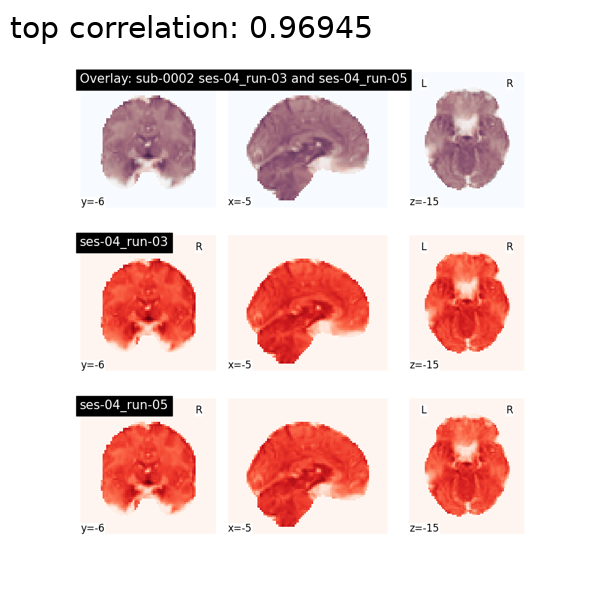

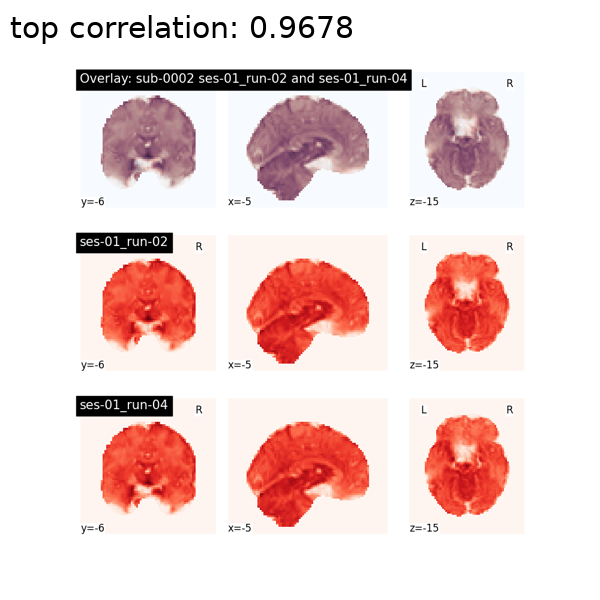

In [315]:
plot_corr_pair(plot_dir='/Volumes/derivatives/fmriprep_qc/runwisecorr', 
                corr_df=corr_df, 
                index_list=top_three_indices,
                title="top correlation")
 

## plot bottom 3 correlation pairs

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf


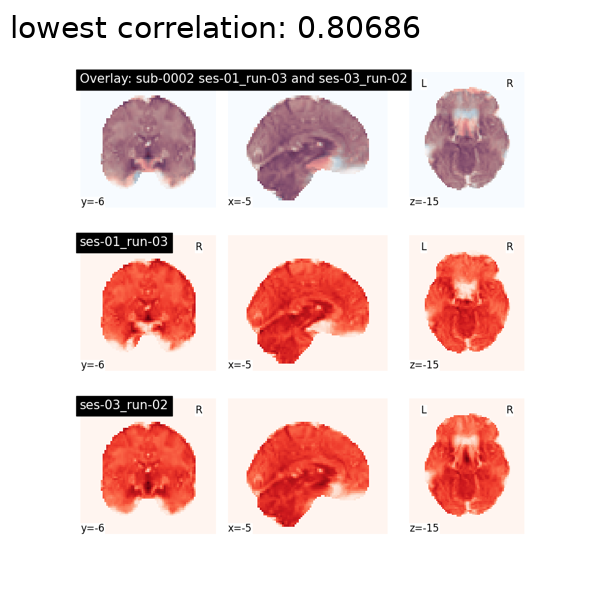

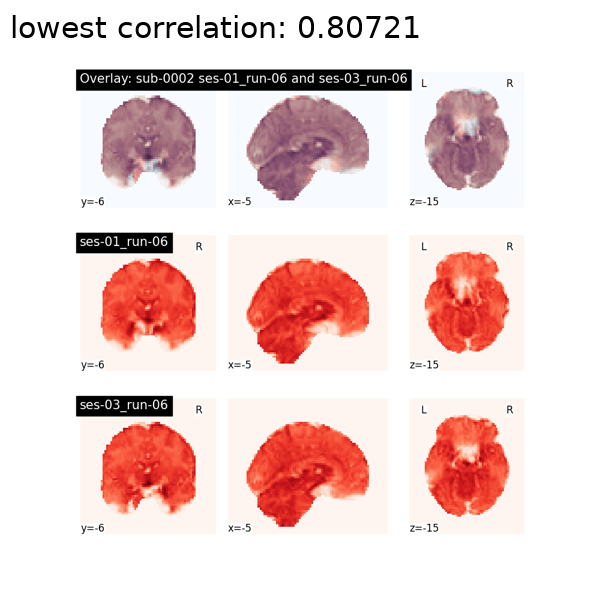

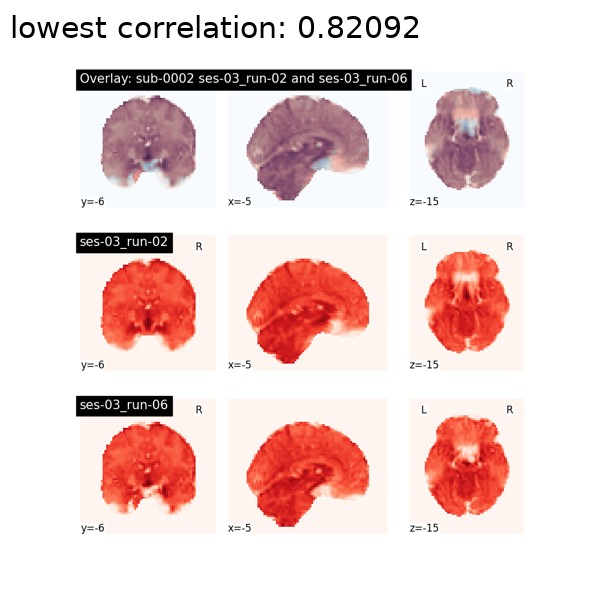

In [317]:
plot_corr_pair(plot_dir='/Volumes/derivatives/fmriprep_qc/runwisecorr', 
                corr_df=corr_df, 
                index_list=bottom_three_indices,
                title="lowest correlation")
 

## plot masked image


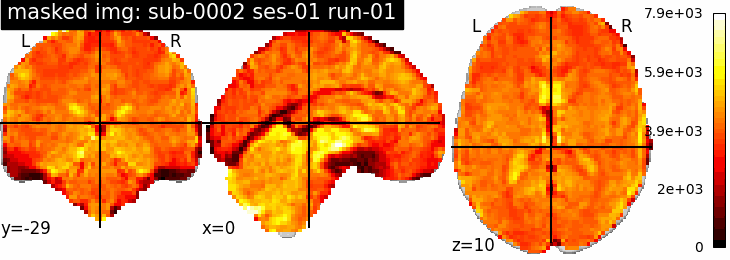

In [325]:
masked_fname = join(plot_dir, sub, f"animation-masked_{sub}.gif")
b64 = base64.b64encode(open(masked_fname,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

## sbref


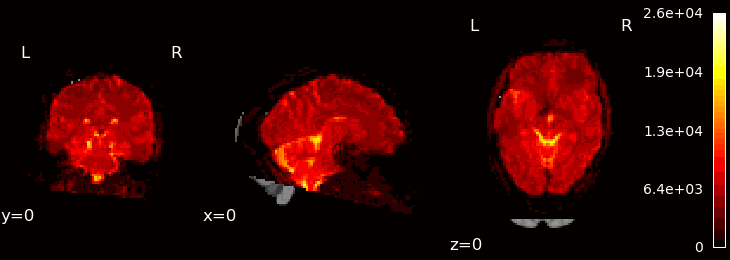

In [327]:
sbref_fname = join(f"/Volumes/derivatives/fmriprep_qc/sbref/animation-sbref_{sub}.gif")
b64 = base64.b64encode(open(img_name,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))